# Multiagent Reinforcement Learning - Collaboration/Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

This project also uses Visdom to monitor training results in real-time.  Please see the README for details on how to run the Visdom server.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
from collections import deque
import visdom_plotter
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [2]:
global plotter
# Instantiate Visdom to monitor training
plotter = visdom_plotter.VisdomLinePlotter(env_name='MARL Collaboration/Competition')

INFO:visdom:Visdom successfully connected to server


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="C:/Users/pjsch/OneDrive/Desktop/Udacity_RL_Nanodegree/Udacity_RL_Nanodegree_Projects/MARL_Collaboration_Competition/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Instantiate The Agent

In [6]:
agent = Agent(state_size, action_size, random_seed=42, num_agents=2)

### 4. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [7]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(2)                                   # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

### 5. Define Training Method

In [8]:
def train(n_episodes=2500):

    """Deep Deterministic Policy Gradients (DDPG)
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    scores = []                                                 # list containing scores from each episode
    scores_average = []                                         # list containing average score from each episode
    scores_window = deque(maxlen=100)                           # last 100 scores
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        score = np.zeros(2)                                     # initialize the scores for each agent
        while True:
            action = agent.act(state)                           # get action from state from agent
            env_info = env.step(action)[brain_name]             # send the action to the environment
            next_state = env_info.vector_observations           # get the next state
            reward = env_info.rewards                           # get the reward
            score += reward                                     # append award
            done = env_info.local_done                          # check for done
            agent.step(state, action, reward, next_state, done) # save experience
            state = next_state                                  # set current state for next action
            if np.any(done):                                    # exit loop if episode finished
                break 
        scores_window.append(np.max(score))                     # save most recent and highest score between agents in window
        scores.append(np.max(score))                            # save most recent and highest score between agents for printing later
        scores_average.append(np.mean(scores_window))           # save average scores for printing later
        print('\rEpisode {}\tReward: {:.2f}\tAverage Reward: {:.2f}'.format(i_episode, np.max(score), np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tMax Score: {:.2f}'.format(i_episode, np.mean(scores_window), np.max(scores_window)))
            
        plotter.plot('Score', 'Score', i_episode, np.max(score))                            # Send plot to Visdom server
        plotter.plot('Average', 'Average Score', i_episode, np.mean(scores_window))         # Send plot to Visdom server

        if np.mean(scores_window)>=0.5: # environment is solved when average over 100 episodes is 0.5
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores, scores_average

### 6. Reinit Agent, Train Model and Store Scores

In [9]:
agent = Agent(state_size, action_size, random_seed=42, num_agents=2)

scores, scores_average = train()

Cuda is available is: True
cuda:0
Episode 100	Average Score: 0.01	Max Score: 0.19
Episode 200	Average Score: 0.00	Max Score: 0.10
Episode 300	Average Score: 0.01	Max Score: 0.10
Episode 400	Average Score: 0.03	Max Score: 0.20
Episode 500	Average Score: 0.05	Max Score: 0.20
Episode 600	Average Score: 0.09	Max Score: 0.50
Episode 700	Average Score: 0.50	Max Score: 2.70

Environment solved in 700 episodes!	Average Score: 0.50


### 7. Plot Scores and Score Average Per Episode

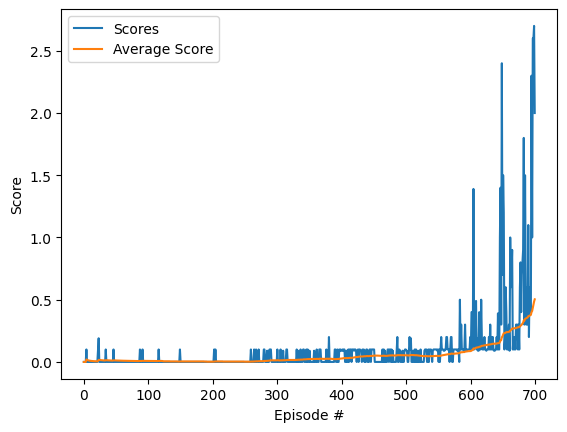

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Scores')
plt.plot(np.arange(len(scores_average)), scores_average, label='Average Score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

### 8. Define Method To Run Saved Agent

In [17]:
def run(agent):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations               # get the current state
    score = np.zeros(2)                                # initialize the scores for each agent
    while True:
    #for i in range(1000):
        action = agent.act(state)                      # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations      # get the next state
        reward = env_info.rewards                      # get the reward
        score += reward                                # update the score
        done = env_info.local_done                     # see if episode has finished
        state = next_state                             # roll over the state to next time step
        if np.any(done):                               # exit loop if episode finished
            break

    print("Score: {}".format(np.max(score)))

### 9. Reinit Agent, Load and Run Saved Model

In [20]:
agent = Agent(state_size, action_size, random_seed=42, num_agents=2)
actor_state_dict = torch.load('checkpoint_actor.pth')   # load actor checkpoint
critic_state_dict = torch.load('checkpoint_critic.pth') # load critic checkpoint
agent.actor_local.load_state_dict(actor_state_dict)     
agent.critic_local.load_state_dict(critic_state_dict)
run(agent)

Cuda is available is: True
cuda:0
Score: 2.600000038743019
